In [2]:
!pip list --format freeze > requirements.txt

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from pycaret.classification import *
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
df = pd.read_parquet('dataset_final_sem_reamostragem.parquet')

df = df.drop(columns=['tensao_1', 'corrente_499'])

df.head()

,temp,irrad,label_sujeira,label_sombra,corrente_1,tensao_2,corrente_2,tensao_3,corrente_3,tensao_4,...,corrente_494,tensao_495,corrente_495,tensao_496,corrente_496,tensao_497,corrente_497,tensao_498,corrente_498,tensao_499
0,57.27,1015.756377,Limpo,Ensaio 1,9.633357,14.642546,9.623563,24.771224,9.617146,34.459525,...,0.040642,803.358322,0.040642,803.358322,0.040642,803.358322,0.040642,803.358322,0.040642,804.018888
1,36.37,1040.200000,Limpo,Ensaio 1,9.670000,17.000000,9.660000,25.700000,9.640000,34.800000,...,0.010000,881.500000,0.010000,881.100000,0.010000,881.100000,0.010000,881.100000,0.010000,882.700000
2,47.79,1094.686567,Limpo,Ensaio 1,10.395877,15.523300,10.382924,25.651979,10.374368,35.780657,...,0.029947,825.157000,0.029947,825.157000,0.029947,825.157000,0.029947,824.936811,0.029947,825.817566
3,47.79,1098.200000,Limpo,Ensaio 1,10.400000,15.500000,10.380000,25.700000,10.370000,35.800000,...,0.030000,825.200000,0.030000,825.200000,0.030000,825.200000,0.030000,824.900000,0.030000,825.800000
4,50.79,1183.952853,Limpo,Ensaio 1,10.673835,16.404055,10.673835,27.853865,10.673835,39.083487,...,0.029947,820.753226,0.029947,820.753226,0.029947,820.753226,0.029947,820.753226,0.029947,821.633981


In [ ]:
c_cols = [c for c in df.columns if 'corrente' in c]
v_cols = [c for c in df.columns if 'tensao' in c]

# Remoção das variáveis correlacionadas da corrente
colunas_com_alta_correlacao = []

# percorrer as colunas do dataframe
for coluna in tqdm(c_cols):

    if coluna in colunas_com_alta_correlacao: continue 

    # calcular a correlação entre a coluna atual e as demais colunas
    corr = df[c_cols].corr()[coluna].abs()

    # selecionar as colunas com correlação maior que 90%
    colunas_com_alta_correlacao.extend(corr[(corr > 0.9) & (corr < 1.0)].index.tolist())

df = df.drop(columns=colunas_com_alta_correlacao)

# Remoção das variáveis correlacionadas da tensão
colunas_com_alta_correlacao = []

# percorrer as colunas do dataframe
for coluna in tqdm(v_cols):

    if coluna in colunas_com_alta_correlacao: continue 

    # calcular a correlação entre a coluna atual e as demais colunas
    corr = df[v_cols].corr()[coluna].abs()

    # selecionar as colunas com correlação maior que 90%
    colunas_com_alta_correlacao.extend(corr[(corr > 0.9) & (corr < 1.0)].index.tolist())

df = df.drop(columns=colunas_com_alta_correlacao)

In [ ]:
c_cols = [c for c in df.columns if 'corrente' in c]
v_cols = [c for c in df.columns if 'tensao' in c]

c_cols + v_cols

In [39]:
# df = df[['temp', 'irrad', 'label_sujeira', 'label_sombra', 'corrente_1', 'tensao_499', 'tensao_3', 'corrente_7']]
df = df[['temp', 'irrad', 'label_sujeira', 'label_sombra', 'corrente_1', 'tensao_499']]

In [40]:
df.shape

(569, 6)

In [42]:
exp = setup(
    data=df,
    target='label_sujeira',
    ignore_features=['label_sombra'],
    # categorical_features=['label_sujeira'],
    train_size=0.8,
    fold=5,
    data_split_shuffle=True,
    data_split_stratify=True,
    remove_perfect_collinearity=False,
    # remove_outliers=True,
    normalize=True,    
    # transformation=True,
    # pca=True,
    # polynomial_features=True,
    # trigonometry_features=True,
    verbose=False,
    session_id=42,
    use_gpu=True
)

Text(value="Following data types have been inferred automatically, if they are correct press enter to continue…

,Data Type
temp,Numeric
irrad,Numeric
corrente_1,Numeric
tensao_499,Numeric
label_sujeira,Label


In [43]:
top10 = compare_models(fold=5, turbo=True, verbose=True, n_select=10)
res = pull()
res

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.9978,0.0000,1.0000,0.9958,0.9979,0.9956,0.9956,0.0080
ridge,Ridge Classifier,0.9978,0.0000,1.0000,0.9958,0.9979,0.9956,0.9956,0.0100
qda,Quadratic Discriminant Analysis,0.9978,0.9977,1.0000,0.9958,0.9979,0.9956,0.9956,0.0100
lda,Linear Discriminant Analysis,0.9978,0.9977,1.0000,0.9958,0.9979,0.9956,0.9956,0.0100
lr,Logistic Regression,0.9912,0.9994,0.9875,0.9958,0.9915,0.9824,0.9827,0.0140
gbc,Gradient Boosting Classifier,0.9758,0.9951,0.9832,0.9708,0.9769,0.9515,0.9517,0.0860
et,Extra Trees Classifier,0.9758,0.9946,0.9663,0.9871,0.9765,0.9516,0.9521,0.3360
ada,Ada Boost Classifier,0.9736,0.9847,0.9789,0.9710,0.9749,0.9471,0.9473,0.0880
lightgbm,Light Gradient Boosting Machine,0.9736,0.9950,0.9748,0.9748,0.9747,0.9472,0.9473,0.3440
rf,Random Forest Classifier,0.9626,0.9885,0.9578,0.9703,0.9637,0.9252,0.9259,0.3360


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.9978,0.0000,1.0000,0.9958,0.9979,0.9956,0.9956,0.008
ridge,Ridge Classifier,0.9978,0.0000,1.0000,0.9958,0.9979,0.9956,0.9956,0.010
qda,Quadratic Discriminant Analysis,0.9978,0.9977,1.0000,0.9958,0.9979,0.9956,0.9956,0.010
lda,Linear Discriminant Analysis,0.9978,0.9977,1.0000,0.9958,0.9979,0.9956,0.9956,0.010
lr,Logistic Regression,0.9912,0.9994,0.9875,0.9958,0.9915,0.9824,0.9827,0.014
gbc,Gradient Boosting Classifier,0.9758,0.9951,0.9832,0.9708,0.9769,0.9515,0.9517,0.086
et,Extra Trees Classifier,0.9758,0.9946,0.9663,0.9871,0.9765,0.9516,0.9521,0.336
ada,Ada Boost Classifier,0.9736,0.9847,0.9789,0.9710,0.9749,0.9471,0.9473,0.088
lightgbm,Light Gradient Boosting Machine,0.9736,0.9950,0.9748,0.9748,0.9747,0.9472,0.9473,0.344
rf,Random Forest Classifier,0.9626,0.9885,0.9578,0.9703,0.9637,0.9252,0.9259,0.336


In [44]:
def plot_accuracy_boxplots(dff: pd.DataFrame, title: str):
    
    dff['Accuracy'] = dff['Accuracy'] * 100
    # display(dff)
    sns.boxplot(data=dff, x='Accuracy', y='model')

    plt.title(title)
    plt.gca().set_xlim([50., 100.])
    plt.xlabel("Acurácia (%)")
    plt.ylabel("")
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'figures/{title}.jpg')
    plt.close()

In [45]:
results = []

for model in top10:
    clf = create_model(model)
    res = pull()
    res['model'] = model.__repr__().split('(')[0]

    results.append(res[['model', 'Accuracy']])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9670,0.9755,0.9375,1.0000,0.9677,0.9341,0.9361
1,0.9780,0.9961,0.9792,0.9792,0.9792,0.9559,0.9559
2,0.9780,0.9995,1.0000,0.9592,0.9792,0.9559,0.9569
3,0.9451,0.9840,0.9362,0.9565,0.9462,0.8901,0.8903
4,0.9451,0.9874,0.9362,0.9565,0.9462,0.8901,0.8903
Mean,0.9626,0.9885,0.9578,0.9703,0.9637,0.9252,0.9259
Std,0.0149,0.0086,0.0268,0.0171,0.0149,0.0298,0.0300


In [46]:
df_res = pd.concat(results)
df_res.query("model == 'RidgeClassifier'")
df_res = df_res.loc[[0, 1, 2, 3, 4]]
plot_accuracy_boxplots(df_res, 'Acurácias da validação cruzada - Experimento 1')

In [47]:
clf = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9451,0.9867,0.9375,0.9574,0.9474,0.8899,0.8901
1,0.9890,0.9995,0.9792,1.0000,0.9895,0.9780,0.9782
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.9451,0.9942,0.9574,0.9375,0.9474,0.8899,0.8901
4,0.9890,0.9947,1.0000,0.9792,0.9895,0.9780,0.9782
Mean,0.9736,0.9950,0.9748,0.9748,0.9747,0.9472,0.9473
Std,0.0237,0.0048,0.0244,0.0244,0.0227,0.0474,0.0474


In [48]:
preds = predict_model(clf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9649,0.9991,0.9500,0.9828,0.9661,0.9298,0.9303


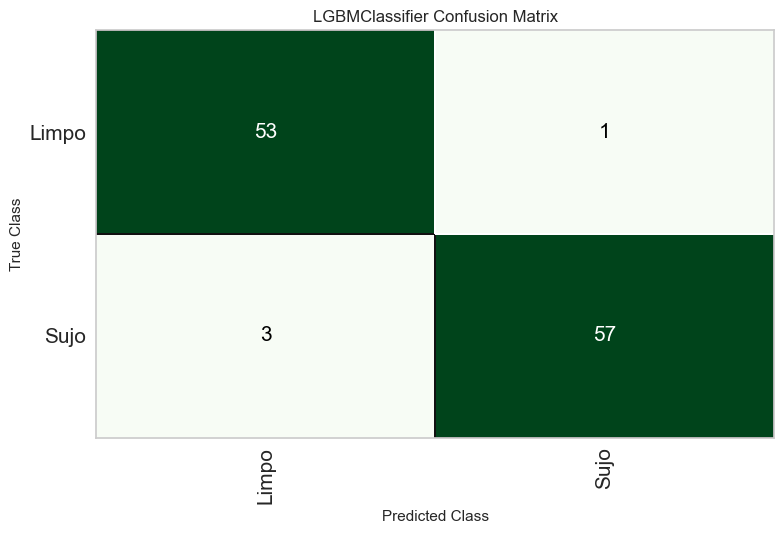

In [49]:
plot_model(clf, 'confusion_matrix')

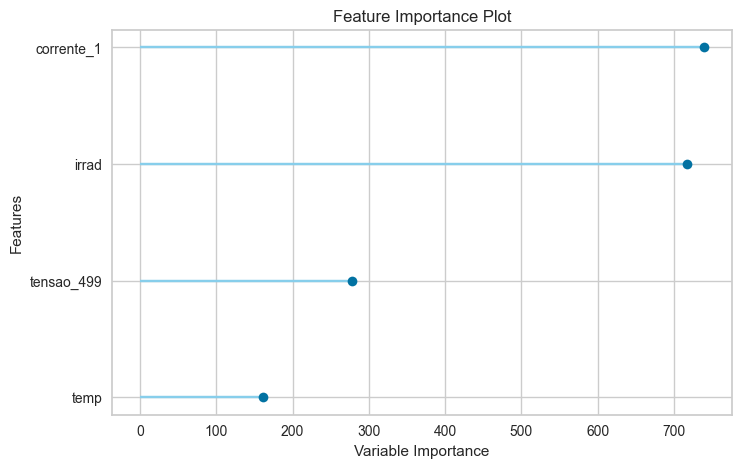

In [50]:
plot_model(clf, 'feature')

<AxesSubplot: >

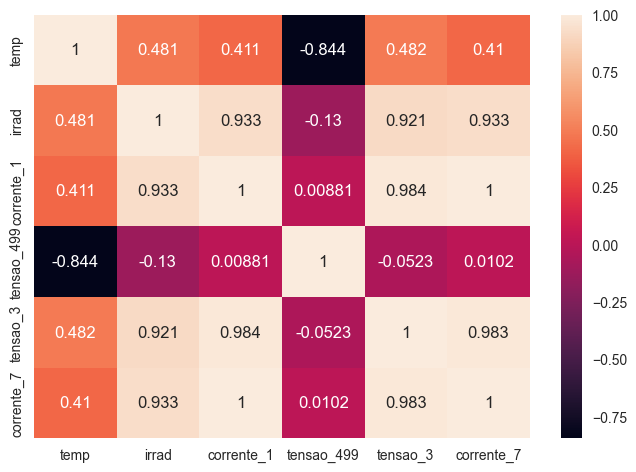

In [13]:
corr = df.corr()
sns.heatmap(corr, annot=True, fmt='.3g')

In [51]:
clf = create_model('ridge', verbose=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9890,0.0000,1.0000,0.9792,0.9895,0.9780,0.9782
Mean,0.9978,0.0000,1.0000,0.9958,0.9979,0.9956,0.9956
Std,0.0044,0.0000,0.0000,0.0083,0.0042,0.0088,0.0087


In [52]:
preds = predict_model(clf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [54]:
df

,temp,irrad,label_sujeira,label_sombra,corrente_1,tensao_499
0,57.27,1015.756377,Limpo,Ensaio 1,9.633357,804.018888
1,36.37,1040.200000,Limpo,Ensaio 1,9.670000,882.700000
2,47.79,1094.686567,Limpo,Ensaio 1,10.395877,825.817566
3,47.79,1098.200000,Limpo,Ensaio 1,10.400000,825.800000
4,50.79,1183.952853,Limpo,Ensaio 1,10.673835,821.633981
...,...,...,...,...,...,...
564,65.62,931.188316,Sujo,Ensaio 6,7.838541,777.155872
565,66.27,963.136250,Sujo,Ensaio 6,8.126044,772.091533
566,66.27,966.200000,Sujo,Ensaio 6,8.130000,772.100000
567,66.30,990.385958,Sujo,Ensaio 6,8.368906,773.632853


In [55]:
sample = df.copy().drop(columns=['label_sombra']).round(1)

In [56]:
sample

,temp,irrad,label_sujeira,corrente_1,tensao_499
0,57.3,1015.8,Limpo,9.6,804.0
1,36.4,1040.2,Limpo,9.7,882.7
2,47.8,1094.7,Limpo,10.4,825.8
3,47.8,1098.2,Limpo,10.4,825.8
4,50.8,1184.0,Limpo,10.7,821.6
...,...,...,...,...,...
564,65.6,931.2,Sujo,7.8,777.2
565,66.3,963.1,Sujo,8.1,772.1
566,66.3,966.2,Sujo,8.1,772.1
567,66.3,990.4,Sujo,8.4,773.6


<Figure size 800x600 with 0 Axes>

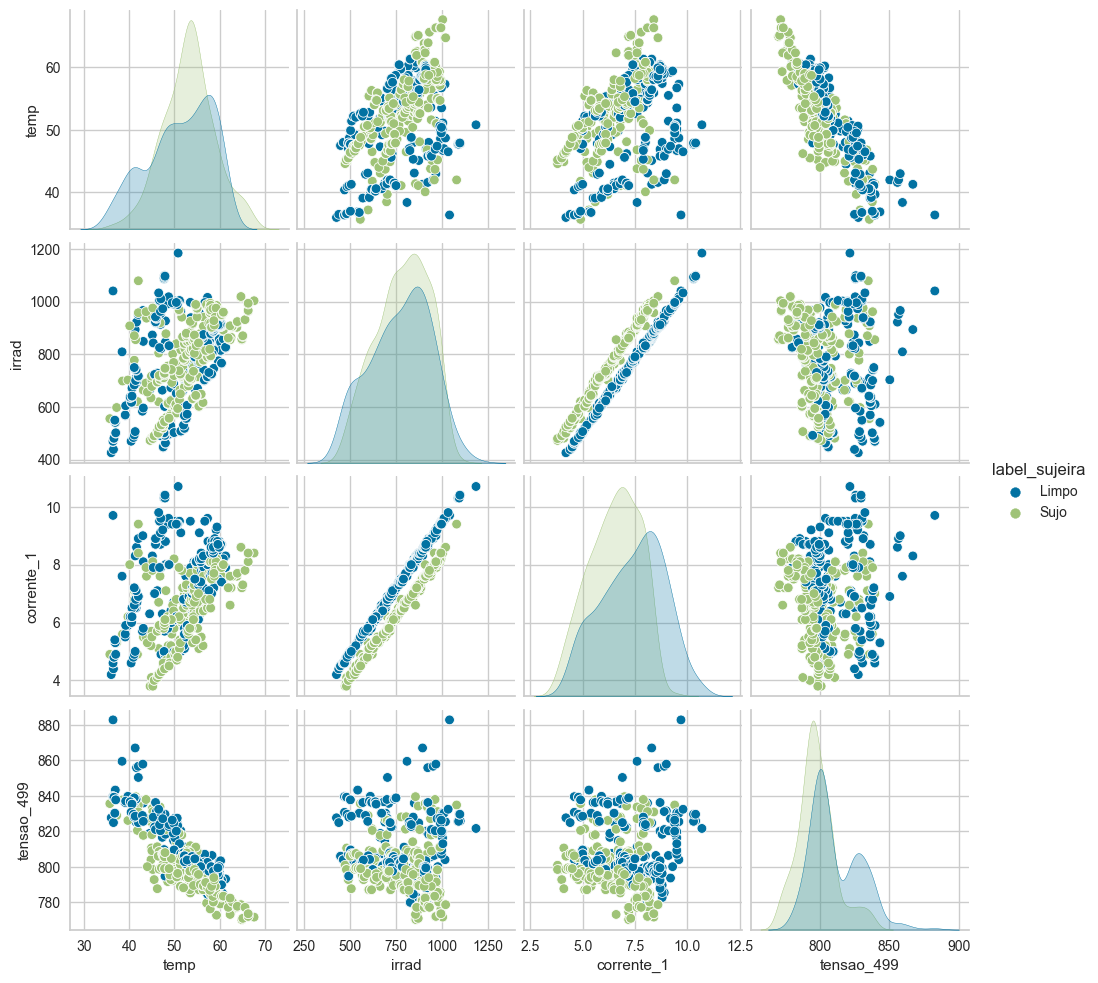

In [60]:
fig = plt.figure(figsize=(8, 6))
sns.pairplot(data=sample, hue='label_sujeira', corner=True)

plt.show()
plt.close()

In [53]:
sns.pairplot?

Signature:
sns.pairplot(
    data,
    *,
    hue=None,
    hue_order=None,
    palette=None,
    vars=None,
    x_vars=None,
    y_vars=None,
    kind='scatter',
    diag_kind='auto',
    markers=None,
    height=2.5,
    aspect=1,
    corner=False,
    dropna=False,
    plot_kws=None,
    diag_kws=None,
    grid_kws=None,
    size=None,
)
Docstring:
Plot pairwise relationships in a dataset.

By default, this function will create a grid of Axes such that each numeric
variable in ``data`` will by shared across the y-axes across a single row and
the x-axes across a single column. The diagonal plots are treated
differently: a univariate distribution plot is drawn to show the marginal
distribution of the data in each column.

It is also possible to show a subset of variables or plot different
variables on the rows and columns.

This is a high-level interface for :class:`PairGrid` that is intended to
make it easy to draw a few common styles. You should use :class:`PairGrid`
directly if you